# 자전거 대여 데이터

- 2011년부터 2012년까지 2년간의 자전거 대여 데이터
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합
- 한 시간 간격으로 기록됨
- 훈련 데이터 : 매달 1일부터 19일까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록
- 피처
    - datetime : 기록 일시(1시간 간격)
    - season : 계절
        - 1 : 봄(1분기)
        - 2 : 여름(2분기)
        - 3 : 가울(3분기)
        - 4 : 겨울(4분기)
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음
    - holiday : 공휴일 여부(0: 공휴일 아님, 1: 공휴일)
    - workingday : 근무일 여부 (0: 근무일 아님, 1: 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주
    - weather : 날씨
        - 1: 맑음
        - 2: 옅은 안개, 약간 흐림
        - 3: 약간의 눈, 약간의 비와 천둥 번개, 흐림
        - 4: 폭우와 천둥 번개, 눈과 짙은 안개
        - 숫자가 클수록 날씨가 안좋음
    - temp: 실제 온도
    - atemp: 체감온도
    - humidity: 상대습도
    - windspeed: 풍속
    - casual: 등록되지 않은 사용자(비회원) 수
    - registered: 등록된 사용자(회원) 수
    - count: 자전거 대여 수량
- 종속변수: count
- 평가지표: RMSE(Root Mean Squared Logarithmic Error)

In [153]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
train = pd.read_csv("./data/bike/train.csv")
test = pd.read_csv("./data/bike/test.csv")
sample = pd.read_csv("./data/bike/sampleSubmission.csv")

In [155]:
def rmsle(y_true, y_pred, convertExp=True):
    """
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    """
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred) ** 2))

    return output

In [156]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [157]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


- 년/월/일까지 다르고 시간부터 같으므로 datetime 시간 전처리 필요
- train 에 있는 casual, registered 컬럼이 test엔 없으므로 삭제


In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [159]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])


train["year"] = train["datetime"].dt.year
test["year"] = test["datetime"].dt.year

train["month"] = train["datetime"].dt.month
test["month"] = test["datetime"].dt.month

train["time"] = train["datetime"].dt.time
test["time"] = test["datetime"].dt.time

In [160]:
le = LabelEncoder()
train["time"] = le.fit_transform(train["time"])
test["time"] = le.transform(test["time"])

In [161]:
train.drop(["casual", "registered"], axis=1, inplace=True)

In [162]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
 10  year        10886 non-null  int32         
 11  month       10886 non-null  int32         
 12  time        10886 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(6)
memory usage: 978.2 KB


In [163]:
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,time
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,11.541613
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,6.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,12.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,18.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,23.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,6.915838


- 습도가 0인 경우는 대기중 수증기가 없다는 것이므로 습도가 0인 행은 소거 또는 치환

In [164]:
total_count = train["humidity"].count()
zero_count = train[train["humidity"] == 0]["humidity"].count()
print(f"습도 0 {zero_count}개, 비율 {round((100*zero_count/total_count),2)}%")

습도 0 22개, 비율 0.2%


- 습도 0 이 차지하는 비율은 0.2이므로 소거하는 방법이 낫다고 판단

In [165]:
train.drop(train[train["humidity"] == 0].index, axis=0, inplace=True)

<Axes: >

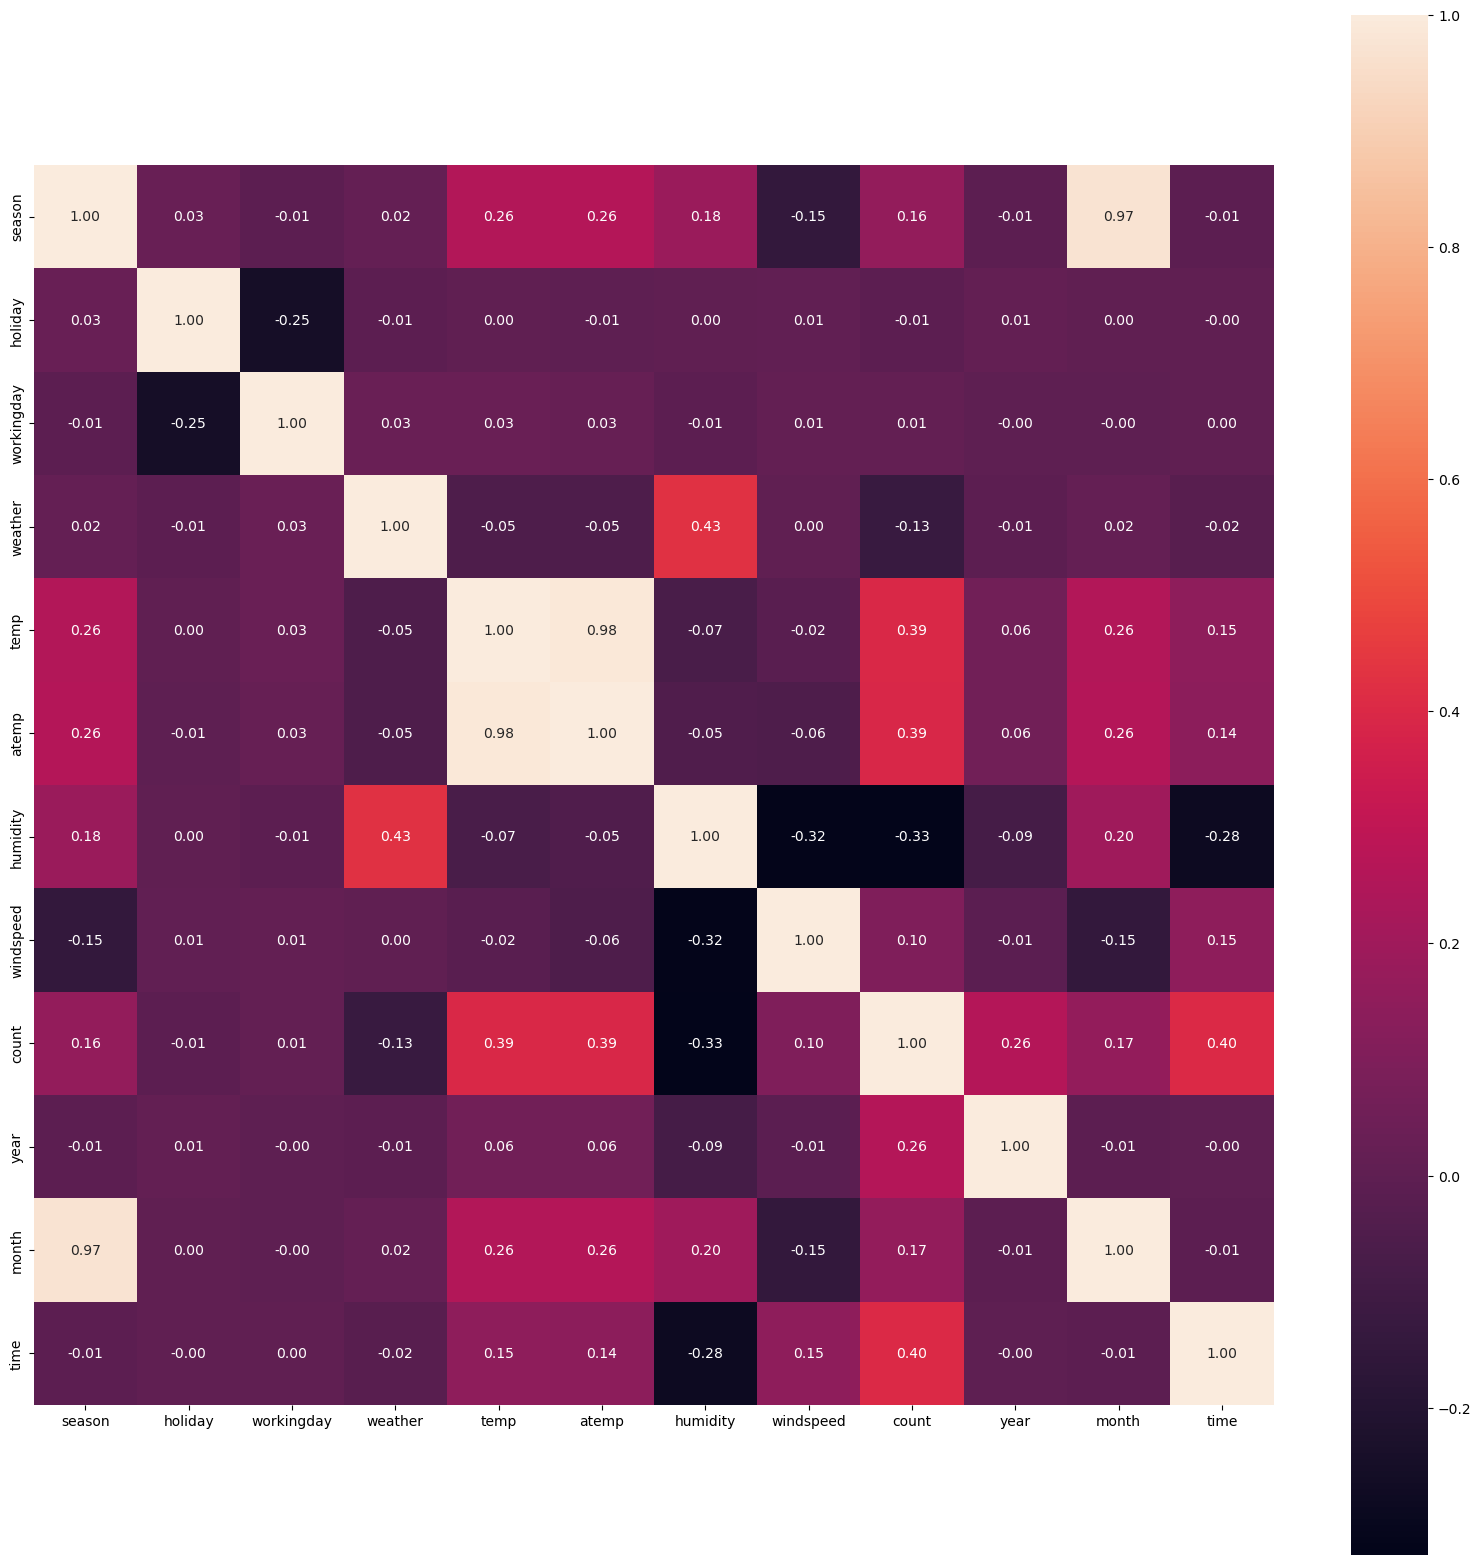

In [166]:
plt.figure(figsize=(20, 20))
train_corr = train.drop("datetime", axis=1).corr()
sns.heatmap(
    train_corr,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=train_corr,
    xticklabels=train_corr,
)

- count와 연관이 있는 컬럼은 temp, atemp, time, humidity
- holiyday, workingday는 미미

#### 불쾌지수

- 불쾌지수(DI) = 0.72(온도(℃) + 습도) + 40.6
- 미국의 온도 단위는 ℉ 이므로 ℃ 변환 하여 계산



|지수|단계|지수범위|대응요령|
|----|----|----|-----|
|4|매우높음|80 이상|전원 불쾌감을 느낌어린이, 노약자 등 더위에 취약한 사람들이 수분을 충분히 섭취하고 야외활동을 자제함에어컨,제습기 등을 이용해 실내 온습도를 조절하거나 에어컨 등이 없을 경우 무더위 쉼터 등으로 이동|
|3|높음|75 이상 80 미만|50% 정도 불쾌감을 느낌어린이, 노약자 등 더위에 취약한 사람들은 12시05시 사이에는 야외활동을 자제하거나 가벼운 옷을 입기 에어컨, 제습기 등을 이용해 내온습도를 조절|
|2|보통|68 이상 75 미만	|불쾌감을 나타내기 시작함 어린이, 노약자 등 더위에 취약한 사람들은 야외활동 시 가벼운 옷을 입기|
|1|낮음|68 미만	|전원 쾌적함을 느낌|

In [167]:
def DI_in_df(df):  # 불쾌지수
    FtoC = (df["temp"] - 32) * 5 / 9
    df["DI"] = (FtoC + df["humidity"]) * 0.72 + 40.6


def DI_n(x):  # 불쾌지수 범주화
    result = 0
    if x >= 80:
        result = 4
    elif x >= 75:
        result = 3
    elif x >= 68:
        result = 2
    else:
        result = 1
    return result

In [168]:
FtoC = (train["temp"] - 32) * 5 / 9

train_DI = train.copy()
train_DI["DI"] = (FtoC + train_DI["humidity"]) * 0.72 + 40.6
# train_DI["DI"] = train_DI["DI"].apply(DI_n)

In [169]:
train_DI.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,time,DI
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,0,90.056
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,89.008
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2,89.008
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,3,85.736
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,4,85.736


<Axes: >

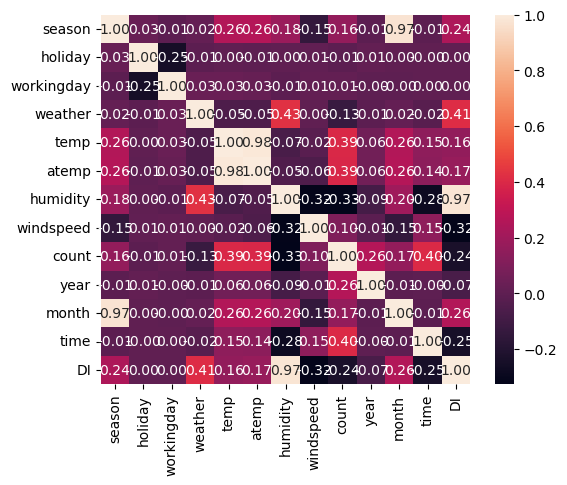

In [170]:
train_DI_corr = train_DI.drop("datetime", axis=1).corr()
sns.heatmap(
    train_DI_corr,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=train_DI_corr,
    xticklabels=train_DI_corr,
)

In [171]:
train.columns
feat_col = [
    "season",
    "weather",
    "holiday",
    "workingday",
    "DI",
    "temp",
    "atemp",
    "humidity",
    "windspeed",
    "time",
]

In [172]:
fig = plt.figure(figsize=(15, 15))
axes = []
for i in range(1, 6):
    axes.append(fig.add_subplot(3, 2, i))

for ax, c in zip(axes, feat_col):
    sns.barplot(data=train_DI, x=c, y="count", ax=ax)
    ax.set_title(c)

- 3분기에 가장 많이탐
- 공휴일 관계없이 일정, 자전거 대여에 큰 영향을 미치지 않음
- 날씨가 좋을수록 많이 타며, 의외로 날씨 3보다 4가 더 많음
- 불쾌지수가 낮을수록 빌리는 경향이 높음

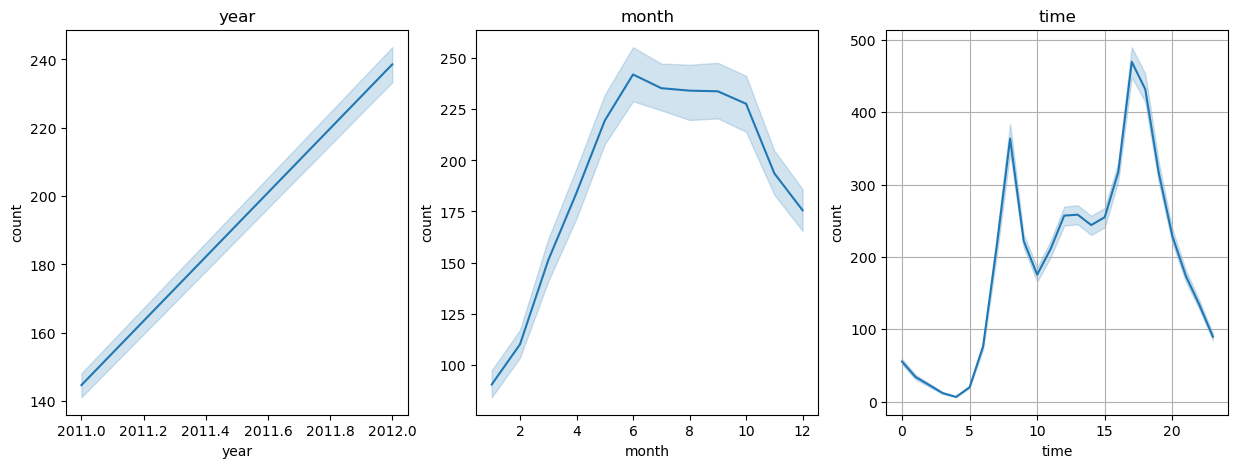

In [ ]:
date = ["year", "month", "time"]


# plt.xlim(0, 24)
# plt.xticks(np.arange(0, 24))


# sns.lineplot(data=train, x="temp", y="count")
# sns.lineplot(data=train, x="atemp", y="count")

fig = plt.figure(figsize=(15, 5))
axes = []
for i in range(1, 4):
    axes.append(fig.add_subplot(1, 3, i))

for ax, c in zip(axes, date):
    sns.lineplot(data=train, x=c, y="count", ax=ax)
    ax.set_title(c)
plt.grid()
plt.show()

- 매해가 지날수록 증가하는 추세
- 주로 6~10월에 많이 탐
- 8시와, 18~19시에 많이 빌리는 것으로 보여짐

In [ ]:
train_x = train.drop("count", axis=1)
train_y = train["count"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, random_state=3056)
x_train.shape, x_test.shape

((8148, 12), (2716, 12))

In [ ]:
ss = StandardScaler()

In [ ]:
x_train.drop("datetime", axis=1, inplace=True)
x_test.drop("datetime", axis=1, inplace=True)
scaled_train_x = ss.fit_transform(x_train)
scaled_test_x = ss.transform(x_test)
scaled_x = ss.transform(train_x.drop("datetime", axis=1))

In [ ]:
scaled_train_x.shape

(8148, 11)

# 선형회귀 불쾌지수 미포함

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(scaled_train_x, y_train)

LinearRegression()

In [ ]:
lr.score(scaled_test_x, y_test)

0.3851473451917211

In [ ]:
pred = lr.predict(scaled_test_x)

In [ ]:
rmsle(y_test, pred, False)

C:\Users\ITSC\AppData\Local\Temp\ipykernel_18896\3425518746.py:14: RuntimeWarning: invalid value encountered in log
  log_pred = np.nan_to_num(np.log(y_pred + 1))


1.3012720473021664

In [ ]:
lr.fit(scaled_x, train_y)

LinearRegression()

In [ ]:
lr.score(scaled_x, train_y)

0.39089229063827513

# 선형회귀 불쾌지수 포함

In [ ]:
train_x_DI = train_DI.drop("count", axis=1)
train_y = train_DI["count"]

x_train_DI, x_test_DI, y_train, y_test = train_test_split(
    train_x_DI, train_y, random_state=3056
)


ss = StandardScaler()

x_train_DI.drop("datetime", axis=1, inplace=True)
x_test_DI.drop("datetime", axis=1, inplace=True)
scaled_train_x_DI = ss.fit_transform(x_train_DI)
scaled_test_x_DI = ss.transform(x_test_DI)

scaled_x_DI = ss.transform(train_x_DI.drop("datetime", axis=1))

lr_DI = LinearRegression()

In [ ]:
lr_DI.fit(scaled_train_x_DI, y_train)

LinearRegression()

In [ ]:
lr_DI.score(scaled_train_x_DI, y_train), lr_DI.score(scaled_test_x_DI, y_test)

(0.3927112653442384, 0.3851473451917211)

In [ ]:
lr.score(scaled_train_x, y_train), lr.score(scaled_test_x, y_test)

(0.3925908871610978, 0.3859557636065307)

In [ ]:
pred_DI = lr_DI.predict(scaled_test_x_DI)

In [ ]:
rmsle(y_test, pred_DI, False), rmsle(y_test, pred, False)

C:\Users\ITSC\AppData\Local\Temp\ipykernel_18896\3425518746.py:14: RuntimeWarning: invalid value encountered in log
  log_pred = np.nan_to_num(np.log(y_pred + 1))
C:\Users\ITSC\AppData\Local\Temp\ipykernel_18896\3425518746.py:14: RuntimeWarning: invalid value encountered in log
  log_pred = np.nan_to_num(np.log(y_pred + 1))


(1.3012720473021662, 1.3012720473021664)

In [ ]:
con_x = sm.add_constant(x_train_DI)
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     478.3
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51850.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8136   BIC:                         1.038e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -346.8602     13.694    -25.329      0.000    -373.704    -320.016
season       -14.1389      5.943     -2.379      0.017     -25.790      -2.488
holiday       -6.0374      9.850     -0.613      0.540     -25.346      13.271
workingday    -1.0723      3.439     -0.312      0.755      -7.814       5.670
weather       -0.9842      2.788     -0.353      0.724      -6.449       4.480
temp        2299.4047     90.709     25.349      0.000    2121.591    2477.218
atemp          5.2689      1.099      4.793      0.000       3.114       7.424
humidity    4134.8453    163.323     25.317      0.000    3814.691    4455.000
windspeed      0.5019      0.209      2.397      0.017       0.091       0.912
year          79.6065      3.141     25.342      0.000      73.449      85.764
month         11.6963      1.933      6.052      0.000       7.908      15.485
time           7.7021      0.239     32.183      0.000       7.233       8.171
DI         -5745.8644    226.822    -25.332      0.000   -6190.493   -5301.236
==============================================================================
Omnibus:                     1603.400   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3115.342
Skew:                           1.196   Prob(JB):                         0.00
Kurtosis:                       4.857   Cond. No.                     5.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
con_x = sm.add_constant(x_train_DI.drop("weather", axis=1))
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     526.2
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51850.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8137   BIC:                         1.038e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -346.6232     13.677    -25.344      0.000    -373.433    -319.813
season       -14.1805      5.942     -2.386      0.017     -25.828      -2.533
holiday       -6.0305      9.849     -0.612      0.540     -25.338      13.277
workingday    -1.1242      3.436     -0.327      0.744      -7.860       5.611
temp        2297.8254     90.594     25.364      0.000    2120.238    2475.413
atemp          5.2816      1.099      4.807      0.000       3.128       7.435
humidity    4132.0084    163.116     25.332      0.000    3812.259    4451.758
windspeed      0.4919      0.207      2.371      0.018       0.085       0.899
year          79.5521      3.137     25.356      0.000      73.402      85.702
month         11.7192      1.932      6.067      0.000       7.933      15.505
time           7.6929      0.238     32.336      0.000       7.227       8.159
DI         -5741.9474    226.538    -25.347      0.000   -6186.020   -5297.875
==============================================================================
Omnibus:                     1604.968   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3120.587
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       4.860   Cond. No.                     5.54e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.08e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
drop_col = ["weather", "workingday"]
con_x = sm.add_constant(x_train_DI.drop(drop_col, axis=1))
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     584.7
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51851.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8138   BIC:                         1.038e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -346.6330     13.676    -25.346      0.000    -373.442    -319.824
season       -14.1948      5.941     -2.389      0.017     -25.842      -2.548
holiday       -5.2420      9.550     -0.549      0.583     -23.961      13.477
temp        2297.8756     90.589     25.366      0.000    2120.298    2475.453
atemp          5.2951      1.098      4.823      0.000       3.143       7.447
humidity    4132.1287    163.107     25.334      0.000    3812.397    4451.860
windspeed      0.4919      0.207      2.371      0.018       0.085       0.899
year          79.5541      3.137     25.358      0.000      73.404      85.704
month         11.7255      1.931      6.071      0.000       7.940      15.511
time           7.6938      0.238     32.343      0.000       7.227       8.160
DI         -5742.1145    226.525    -25.349      0.000   -6186.161   -5298.068
==============================================================================
Omnibus:                     1600.799   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3104.938
Skew:                           1.196   Prob(JB):                         0.00
Kurtosis:                       4.851   Cond. No.                     4.97e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
drop_col = ["weather", "workingday", "holiday"]
con_x = sm.add_constant(x_train_DI.drop(drop_col, axis=1))
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     657.8
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51851.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8139   BIC:                         1.038e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -346.5120     13.674    -25.341      0.000    -373.316    -319.708
season       -14.5728      5.901     -2.469      0.014     -26.141      -3.005
temp        2297.0581     90.573     25.361      0.000    2119.512    2474.604
atemp          5.3121      1.097      4.841      0.000       3.161       7.463
humidity    4130.6885    163.079     25.329      0.000    3811.012    4450.365
windspeed      0.4905      0.207      2.365      0.018       0.084       0.897
year          79.5264      3.137     25.354      0.000      73.378      85.675
month         11.8434      1.919      6.171      0.000       8.081      15.606
time           7.6932      0.238     32.343      0.000       7.227       8.159
DI         -5740.1152    226.486    -25.344      0.000   -6184.085   -5296.145
==============================================================================
Omnibus:                     1603.236   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3113.534
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       4.856   Cond. No.                     5.41e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.13e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
drop_col = ["weather", "workingday", "holiday", "temp"]
con_x = sm.add_constant(x_train_DI.drop(drop_col, axis=1))
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     657.8
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51851.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8139   BIC:                         1.038e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.6e+05   6308.492    -25.361      0.000   -1.72e+05   -1.48e+05
season       -14.5728      5.901     -2.469      0.014     -26.141      -3.005
atemp          5.3121      1.097      4.841      0.000       3.161       7.463
humidity      -4.0161      2.141     -1.876      0.061      -8.213       0.181
windspeed      0.4905      0.207      2.365      0.018       0.084       0.897
year          79.5264      3.137     25.354      0.000      73.378      85.675
month         11.8434      1.919      6.171      0.000       8.081      15.606
time           7.6932      0.238     32.343      0.000       7.227       8.159
DI             2.5301      2.979      0.849      0.396      -3.310       8.370
==============================================================================
Omnibus:                     1603.236   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3113.534
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       4.856   Cond. No.                     8.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
drop_col = ["weather", "workingday", "holiday", "temp", "DI"]
con_x = sm.add_constant(x_train_DI.drop(drop_col, axis=1))
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     751.7
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51851.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8140   BIC:                         1.038e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.601e+05   6307.971    -25.373      0.000   -1.72e+05   -1.48e+05
season       -14.5178      5.901     -2.460      0.014     -26.085      -2.951
atemp          6.2294      0.194     32.060      0.000       5.848       6.610
humidity      -2.1993      0.091    -24.198      0.000      -2.377      -2.021
windspeed      0.5253      0.203      2.584      0.010       0.127       0.924
year          79.5911      3.136     25.383      0.000      73.444      85.738
month         11.8363      1.919      6.167      0.000       8.074      15.598
time           7.6905      0.238     32.335      0.000       7.224       8.157
==============================================================================
Omnibus:                     1603.734   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3115.777
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       4.857   Cond. No.                     8.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
drop_col = ["weather", "workingday", "holiday", "temp", "DI", "season"]
con_x = sm.add_constant(x_train_DI.drop(drop_col, axis=1))
model = sm.OLS(list(y_train), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     875.4
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:24:55   Log-Likelihood:                -51854.
No. Observations:                8148   AIC:                         1.037e+05
Df Residuals:                    8141   BIC:                         1.038e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.602e+05   6309.722    -25.386      0.000   -1.73e+05   -1.48e+05
atemp          6.2181      0.194     32.001      0.000       5.837       6.599
humidity      -2.1900      0.091    -24.110      0.000      -2.368      -2.012
windspeed      0.5334      0.203      2.623      0.009       0.135       0.932
year          79.6501      3.137     25.394      0.000      73.502      85.799
month          7.2658      0.482     15.071      0.000       6.321       8.211
time           7.6966      0.238     32.352      0.000       7.230       8.163
==============================================================================
Omnibus:                     1604.420   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3116.634
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       4.856   Cond. No.                     8.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lr_sum = LinearRegression()

In [ ]:
lr_sum.fit(x_train_DI.drop(drop_col, axis=1), y_train)

LinearRegression()

In [ ]:
lr_sum.score(x_test_DI.drop(drop_col, axis=1), y_test)

0.3853427266301741

- 후진 제거법으로 유의미한 성능향상 기대 x

# 랜덤포레스트 불쾌지수 미포함

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, random_state=3056)

In [ ]:
rf.fit(scaled_train_x, y_train)

RandomForestRegressor(n_jobs=-1, random_state=3056)

In [ ]:
pred = rf.predict(x_test)
pred

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([123.38, 124.99, 123.38, ..., 124.99, 164.09, 124.99])

# 랜덤포레스트 불쾌지수 포함

In [ ]:
rf_DI = RandomForestRegressor(n_jobs=-1, random_state=3056)

In [ ]:
rf_DI.fit(x_train_DI, y_train)

RandomForestRegressor(n_jobs=-1, random_state=3056)

In [ ]:
scores = cross_validate(rf_DI, x_train_DI, y_train, return_train_score=True, n_jobs=-1)
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9908694907500584 0.9348470511285238


In [ ]:
rf_DI.score(x_train_DI, y_train), rf_DI.score(x_test_DI, y_test)

(0.9911554770086662, 0.9420302371998346)

In [ ]:
scores_DI = cross_validate(
    rf_DI, x_train_DI, y_train, return_train_score=True, n_jobs=-1
)
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9908694907500584 0.9348470511285238


In [ ]:
rf_DI.fit(scaled_train_x_DI, y_train)

RandomForestRegressor(n_jobs=-1, random_state=3056)

In [ ]:
rf_DI.score(scaled_train_x_DI, y_train), rf_DI.score(scaled_test_x_DI, y_test)

(0.9911405086268664, 0.9420508586099954)

In [ ]:
pred_s_DI = rf_DI.predict(scaled_test_x_DI)

In [ ]:
rmsle(pred_s_DI, y_test, False)

0.3489017012609246

In [ ]:
# print(f"include DI train : {np.mean(scores_DI["train_score"])} test : {np.mean(scores_DI["test_score"])}")
# print(f"exclude DI train : {np.mean(scores["train_score"])} test : {np.mean(scores["test_score"])}")

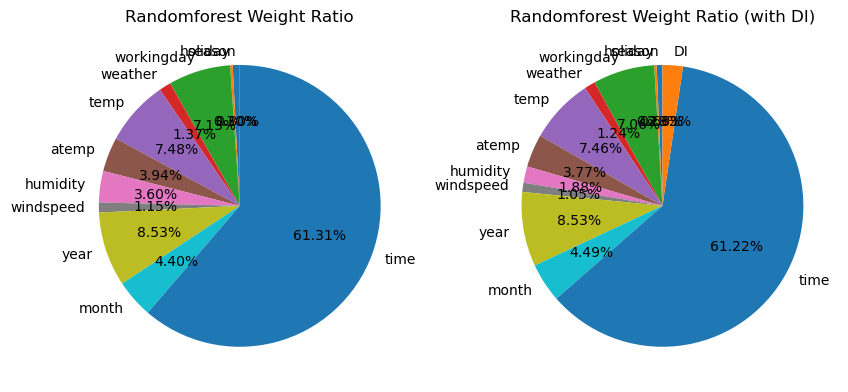

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.pie(
    rf.feature_importances_, labels=x_train.columns, autopct="%1.2f%%", startangle=90
)
ax2.pie(
    rf_DI.feature_importances_,
    labels=x_train_DI.columns,
    autopct="%1.2f%%",
    startangle=90,
)
ax1.set_title("Randomforest Weight Ratio")
ax2.set_title("Randomforest Weight Ratio (with DI)")
plt.show()

# 모델 성능 향상

In [ ]:
drop_DI = train_DI.drop(["datetime", "count"], axis=1)
drop_DI

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,time,DI
0,1,0,0,1,9.84,14.395,81,0.0000,2011,1,0,90.056
1,1,0,0,1,9.02,13.635,80,0.0000,2011,1,1,89.008
2,1,0,0,1,9.02,13.635,80,0.0000,2011,1,2,89.008
3,1,0,0,1,9.84,14.395,75,0.0000,2011,1,3,85.736
4,1,0,0,1,9.84,14.395,75,0.0000,2011,1,4,85.736
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,2012,12,19,70.032
10882,4,0,1,1,14.76,17.425,57,15.0013,2012,12,20,74.744
10883,4,0,1,1,13.94,15.910,61,15.0013,2012,12,21,77.296
10884,4,0,1,1,13.94,17.425,61,6.0032,2012,12,22,77.296


In [ ]:
train_DI = train_DI.drop("datetime", axis=1)

In [ ]:
drop_col = ["count", "workingday", "holiday"]
params = {
    "n_estimators": [200, 300, 400],
    "max_depth": [6, 8, 10, 12],
    # "max_features":
    "min_samples_leaf": [8, 12, 18],
    "min_samples_split": [8, 16, 20],
}

rf_clf = ExtraTreesRegressor(random_state=3056, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=2, verbose=2)
grid_cv.fit(train_DI.drop(drop_col, axis=1), train_y)  # grid.cv.fit(train_x, train_y)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


GridSearchCV(cv=2, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=3056),
             n_jobs=2,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [200, 300, 400]},
             verbose=2)

In [ ]:
drop_col = ["workingday", "holiday"]
estimator = grid_cv.best_estimator_
pred_tune = estimator.predict(x_test_DI.drop(drop_col, axis=1))
pred_tr = estimator.predict(x_train_DI.drop(drop_col, axis=1))

In [ ]:
grid_cv.score(x_train_DI.drop(drop_col, axis=1), y_train), grid_cv.score(
    x_test_DI.drop(drop_col, axis=1), y_test
)

(0.7772843933465892, 0.789108429120695)

In [ ]:
rmsle(y_test, pred_tune, False), rmsle(y_train, pred_tr, False)

(0.592555287984423, 0.59038862626828)

- exclude DI rmslse 0.3153
- not classifier DI rmlse test 0.3140 train 0.3086

## 기술 통계 확인

In [ ]:
drop_col = []
con_x = sm.add_constant(drop_DI)
model = sm.OLS(list(train_y), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     633.1
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69209.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10852   BIC:                         1.385e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -355.3532     11.928    -29.793      0.000    -378.733    -331.973
season       -10.4357      5.185     -2.012      0.044     -20.600      -0.271
holiday       -5.5109      8.472     -0.650      0.515     -22.118      11.096
workingday     0.6887      3.012      0.229      0.819      -5.215       6.592
weather       -1.7149      2.440     -0.703      0.482      -6.498       3.068
temp        2356.0178     79.015     29.818      0.000    2201.135    2510.901
atemp          4.8503      0.955      5.077      0.000       2.978       6.723
humidity    4236.0668    142.253     29.778      0.000    3957.224    4514.909
windspeed      0.5552      0.182      3.043      0.002       0.198       0.913
year          81.5524      2.736     29.806      0.000      76.189      86.916
month         10.7907      1.685      6.405      0.000       7.488      14.093
time           7.7111      0.208     37.007      0.000       7.303       8.120
DI         -5886.4440    197.561    -29.796      0.000   -6273.700   -5499.188
==============================================================================
Omnibus:                     2111.780   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4050.255
Skew:                           1.192   Prob(JB):                         0.00
Kurtosis:                       4.808   Cond. No.                     4.31e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.38e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(con_x.values, i) for i in range(con_x.shape[1])
]
vif["feature"] = con_x.columns
vif.round(1)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,feature
0,0.0,const
1,18.2,season
2,1.1,holiday
3,1.1,workingday
4,1.3,weather
5,inf,temp
6,35.6,atemp
7,inf,humidity
8,1.2,windspeed
9,1.0,year


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): working
- MAX_VIF (>5): atemp

In [ ]:
drop_col = ["workingday"]
con_x = sm.add_constant(drop_DI.drop(drop_col, axis=1))
model = sm.OLS(list(train_y), con_x).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     696.5
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69209.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10853   BIC:                         1.385e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -355.3479     11.927    -29.793      0.000    -378.727    -331.969
season       -10.4244      5.185     -2.010      0.044     -20.588      -0.261
holiday       -5.9969      8.201     -0.731      0.465     -22.072      10.079
weather       -1.6959      2.438     -0.696      0.487      -6.476       3.084
temp        2355.9913     79.011     29.819      0.000    2201.115    2510.867
atemp          4.8430      0.955      5.073      0.000       2.972       6.714
humidity    4236.0023    142.247     29.779      0.000    3957.172    4514.832
windspeed      0.5553      0.182      3.043      0.002       0.198       0.913
year          81.5514      2.736     29.807      0.000      76.188      86.914
month         10.7866      1.685      6.403      0.000       7.484      14.089
time           7.7108      0.208     37.008      0.000       7.302       8.119
DI         -5886.3548    197.552    -29.796      0.000   -6273.593   -5499.117
==============================================================================
Omnibus:                     2115.176   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4062.662
Skew:                           1.193   Prob(JB):                         0.00
Kurtosis:                       4.813   Cond. No.                     5.41e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.51e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(drop_DI.drop(drop_col, axis=1).values, i)
    for i in range(drop_DI.drop(drop_col, axis=1).shape[1])
]
vif["feature"] = drop_DI.drop(drop_col, axis=1).columns
vif.round(1)

,VIF_Factor,feature
0,18.2,season
1,1.0,holiday
2,1.3,weather
3,1601201.7,temp
4,35.6,atemp
5,46432674.9,humidity
6,1.2,windspeed
7,1.0,year
8,18.3,month
9,1.1,time


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): weather
- MAX_VIF (>5): atemp

In [ ]:
drop_col = ["workingday", "weather"]
con_x = sm.add_constant(drop_DI)
model = sm.OLS(list(train_y), con_x.drop(drop_col, axis=1)).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     773.8
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69209.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10854   BIC:                         1.385e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -354.9750     11.915    -29.793      0.000    -378.330    -331.620
season       -10.5061      5.184     -2.027      0.043     -20.667      -0.345
holiday       -5.9221      8.200     -0.722      0.470     -21.996      10.152
temp        2353.5047     78.928     29.818      0.000    2198.791    2508.218
atemp          4.8668      0.954      5.101      0.000       2.997       6.737
humidity    4231.5386    142.099     29.779      0.000    3952.999    4510.078
windspeed      0.5370      0.181      2.974      0.003       0.183       0.891
year          81.4660      2.733     29.807      0.000      76.109      86.823
month         10.8306      1.683      6.434      0.000       7.531      14.130
time           7.6946      0.207     37.163      0.000       7.289       8.100
DI         -5880.1959    197.349    -29.796      0.000   -6267.035   -5493.356
==============================================================================
Omnibus:                     2118.390   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4073.298
Skew:                           1.194   Prob(JB):                         0.00
Kurtosis:                       4.816   Cond. No.                     5.79e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.32e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(drop_DI.drop(drop_col, axis=1).values, i)
    for i in range(drop_DI.drop(drop_col, axis=1).shape[1])
]
vif["feature"] = drop_DI.drop(drop_col, axis=1).columns
vif.round(1)

,VIF_Factor,feature
0,18.1,season
1,1.0,holiday
2,1597923.1,temp
3,35.5,atemp
4,46338158.8,humidity
5,1.2,windspeed
6,1.0,year
7,18.2,month
8,1.1,time
9,141845992.6,DI


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): holiday
- MAX_VIF (>5): atemp

In [ ]:
drop_col = ["workingday", "weather", "holiday"]
con_x = sm.add_constant(drop_DI)
model = sm.OLS(list(train_y), con_x.drop(drop_col, axis=1)).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     870.6
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69209.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10855   BIC:                         1.385e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -354.8607     11.913    -29.787      0.000    -378.213    -331.508
season       -10.9444      5.148     -2.126      0.034     -21.035      -0.854
temp        2352.7273     78.919     29.812      0.000    2198.031    2507.423
atemp          4.8880      0.954      5.126      0.000       3.019       6.757
humidity    4230.1784    142.083     29.773      0.000    3951.670    4508.687
windspeed      0.5363      0.181      2.970      0.003       0.182       0.890
year          81.4398      2.733     29.800      0.000      76.083      86.797
month         10.9677      1.673      6.557      0.000       7.689      14.246
time           7.6943      0.207     37.162      0.000       7.288       8.100
DI         -5878.3076    197.327    -29.790      0.000   -6265.105   -5491.511
==============================================================================
Omnibus:                     2122.044   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.132
Skew:                           1.195   Prob(JB):                         0.00
Kurtosis:                       4.821   Cond. No.                     4.61e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.07e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(drop_DI.drop(drop_col, axis=1).values, i)
    for i in range(drop_DI.drop(drop_col, axis=1).shape[1])
]
vif["feature"] = drop_DI.drop(drop_col, axis=1).columns
vif.round(1)

,VIF_Factor,feature
0,17.9,season
1,1597626.0,temp
2,35.5,atemp
3,46330018.0,humidity
4,1.2,windspeed
5,1.0,year
6,18.0,month
7,1.1,time
8,141821094.6,DI


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): DI
- MAX_VIF (>5): atemp

In [ ]:
drop_col = ["workingday", "weather", "holiday", "DI"]
con_x = sm.add_constant(drop_DI)
model = sm.OLS(list(train_y), con_x.drop(drop_col, axis=1)).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     870.6
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69209.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10855   BIC:                         1.385e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.638e+05   5497.604    -29.790      0.000   -1.75e+05   -1.53e+05
season       -10.9444      5.148     -2.126      0.034     -21.035      -0.854
temp           1.4043      1.036      1.355      0.175      -0.627       3.436
atemp          4.8880      0.954      5.126      0.000       3.019       6.757
humidity      -2.2031      0.080    -27.670      0.000      -2.359      -2.047
windspeed      0.5363      0.181      2.970      0.003       0.182       0.890
year          81.4398      2.733     29.800      0.000      76.083      86.797
month         10.9677      1.673      6.557      0.000       7.689      14.246
time           7.6943      0.207     37.162      0.000       7.288       8.100
==============================================================================
Omnibus:                     2122.044   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.132
Skew:                           1.195   Prob(JB):                         0.00
Kurtosis:                       4.821   Cond. No.                     8.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(drop_DI.drop(drop_col, axis=1).values, i)
    for i in range(drop_DI.drop(drop_col, axis=1).shape[1])
]
vif["feature"] = drop_DI.drop(drop_col, axis=1).columns
vif.round(1)

,VIF_Factor,feature
0,108.5,season
1,274.2,temp
2,311.9,atemp
3,14.4,humidity
4,4.1,windspeed
5,38.6,year
6,82.8,month
7,4.2,time


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): temp
- MAX_VIF (>5): atemp

In [ ]:
drop_col = ["workingday", "weather", "holiday", "DI", "temp"]
con_x = sm.add_constant(drop_DI)
model = sm.OLS(list(train_y), con_x.drop(drop_col, axis=1)).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     994.6
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69210.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10856   BIC:                         1.385e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.639e+05   5496.942    -29.817      0.000   -1.75e+05   -1.53e+05
season       -10.8852      5.148     -2.115      0.034     -20.976      -0.795
atemp          6.1597      0.169     36.494      0.000       5.829       6.491
humidity      -2.2101      0.079    -27.816      0.000      -2.366      -2.054
windspeed      0.5846      0.177      3.302      0.001       0.238       0.932
year          81.5049      2.733     29.828      0.000      76.149      86.861
month         10.9652      1.673      6.555      0.000       7.686      14.244
time           7.6921      0.207     37.151      0.000       7.286       8.098
==============================================================================
Omnibus:                     2122.998   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4090.601
Skew:                           1.195   Prob(JB):                         0.00
Kurtosis:                       4.823   Cond. No.                     8.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(drop_DI.drop(drop_col, axis=1).values, i)
    for i in range(drop_DI.drop(drop_col, axis=1).shape[1])
]
vif["feature"] = drop_DI.drop(drop_col, axis=1).columns
vif.round(1)

,VIF_Factor,feature
0,108.5,season
1,9.7,atemp
2,14.3,humidity
3,3.9,windspeed
4,37.4,year
5,82.8,month
6,4.2,time


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): season
- MAX_VIF (>5): atemp

In [ ]:
drop_col = ["workingday", "weather", "holiday", "DI", "temp", "season"]
con_x = sm.add_constant(drop_DI)
model = sm.OLS(list(train_y), con_x.drop(drop_col, axis=1)).fit().summary()
model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     1159.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -69213.
No. Observations:               10864   AIC:                         1.384e+05
Df Residuals:                   10857   BIC:                         1.385e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.64e+05   5497.528    -29.836      0.000   -1.75e+05   -1.53e+05
atemp          6.1485      0.169     36.440      0.000       5.818       6.479
humidity      -2.2021      0.079    -27.743      0.000      -2.358      -2.046
windspeed      0.5904      0.177      3.335      0.001       0.243       0.937
year          81.5618      2.733     29.845      0.000      76.205      86.919
month          7.5415      0.420     17.949      0.000       6.718       8.365
time           7.6989      0.207     37.183      0.000       7.293       8.105
==============================================================================
Omnibus:                     2122.153   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4088.048
Skew:                           1.195   Prob(JB):                         0.00
Kurtosis:                       4.823   Cond. No.                     8.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [
    variance_inflation_factor(drop_DI.drop(drop_col, axis=1).values, i)
    for i in range(drop_DI.drop(drop_col, axis=1).shape[1])
]
vif["feature"] = drop_DI.drop(drop_col, axis=1).columns
vif.round(1)

,VIF_Factor,feature
0,9.7,atemp
1,14.3,humidity
2,3.9,windspeed
3,34.0,year
4,5.2,month
5,4.2,time


- AIC : 1.384e+05
- 수정 R^2 : 0.39
- MAX_p (>0.05): season
- MAX_VIF (>5): atemp

# rmsle

In [ ]:
pred_DI = rf_DI.predict(x_test_DI)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
rmsle(y_test, pred_DI, False), rmsle(y_test, pred_s_DI, False)

(1.5418043103697174, 0.3489017012609246)

In [ ]:
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,time
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,22


# test 예측

In [ ]:
test_DI = test.copy()
FtoC = (test_DI["temp"] - 32) * 5 / 9
test_DI["DI"] = (FtoC + test_DI["humidity"]) * 0.72 + 40.6
# test_DI["DI"] = test_DI["DI"].apply(DI_n)

In [ ]:
test_DI.drop("datetime", axis=1, inplace=True)

KeyError: "['datetime'] not found in axis"

In [ ]:
test_DI[test_DI["DI"].isnull()]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,time,DI


In [ ]:
pred_test = estimator.predict(test_DI.drop(drop_col, axis=1))

In [ ]:
sample["count"] = pred_test

In [ ]:
sample.head()

,datetime,count
0,2011-01-20 00:00:00,17.459694
1,2011-01-20 01:00:00,15.420492
2,2011-01-20 02:00:00,13.974885
3,2011-01-20 03:00:00,8.236870
4,2011-01-20 04:00:00,3.243974


In [ ]:
sample.to_csv("sampleSubmission.csv", index=False)

PermissionError: [Errno 13] Permission denied: 'sampleSubmission.csv'